# Amazon Deforestation Detection using U-Net

Semantic segmentation of deforested areas in Amazon rainforest using Sentinel-2 satellite imagery.

**Dataset:** [Deforestation Detection Dataset](https://www.kaggle.com/datasets/akhilchibber/deforestation-detection-dataset)  
**Model:** U-Net with ResNet34 encoder (ImageNet pretrained)  
**Framework:** PyTorch + segmentation-models-pytorch

## 1. Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import rioxarray

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Device: mps


In [7]:
# Paths - adjust to your setup
DATASET_PATH = Path("data/raw/archive")  # Original dataset
CHIPS_PATH = Path("data/processed/chips")  # Processed chips
CHIPS_PATH.mkdir(parents=True, exist_ok=True)

# Hyperparameters
CHIP_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 10
LR = 1e-4

## 2. Data Exploration

In [8]:
# Load sample image and mask
img = rioxarray.open_rasterio(DATASET_PATH / "1_CLOUD_FREE_DATASET/2_SENTINEL2/IMAGE_16_GRID/RASTER_0.tif")
mask = rioxarray.open_rasterio(DATASET_PATH / "3_TRAINING_MASKS/MASK_16_GRID/RASTER_0.tif")

print(f"Image: {img.shape} | Mask: {mask.shape}")
print(f"Mask classes: {np.unique(mask.values)} (1=deforestation, 2=forest)")

Image: (4, 2816, 2816) | Mask: (1, 2816, 2816)
Mask classes: [1 2] (1=deforestation, 2=forest)


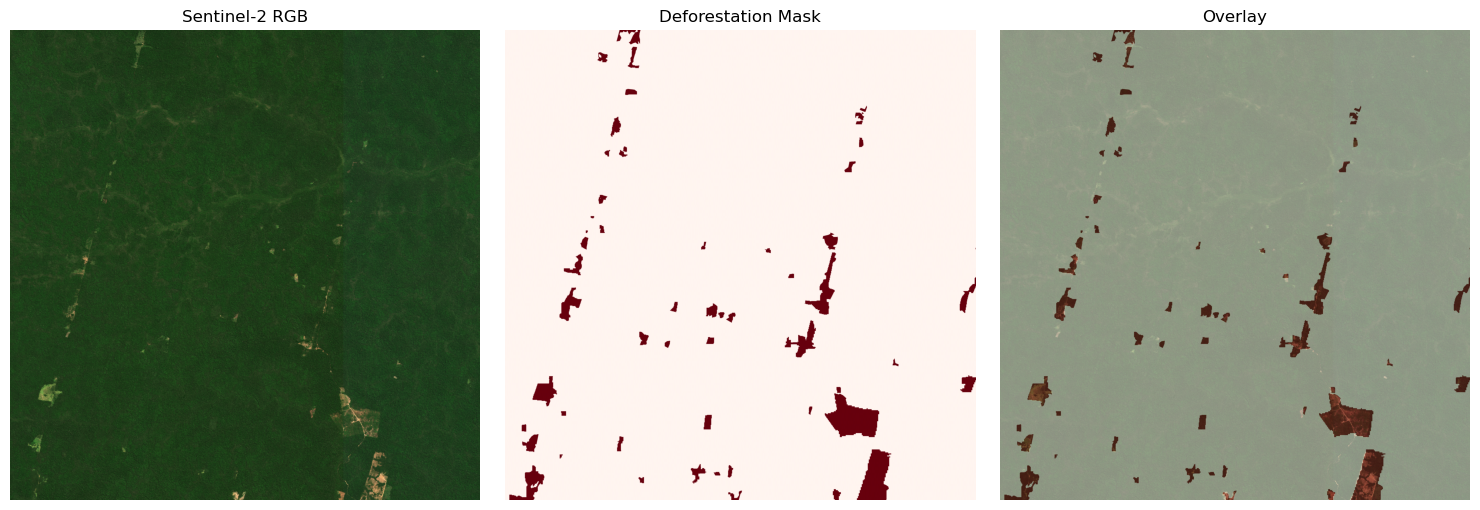

In [9]:
# Visualize
rgb = np.clip(img[[2,1,0]].values.transpose(1,2,0) / 1500, 0, 1)
deforestation = (mask[0].values == 1).astype(float)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(rgb)
axes[0].set_title("Sentinel-2 RGB")
axes[1].imshow(deforestation, cmap="Reds")
axes[1].set_title("Deforestation Mask")
axes[2].imshow(rgb)
axes[2].imshow(deforestation, cmap="Reds", alpha=0.5)
axes[2].set_title("Overlay")
for ax in axes: ax.axis("off")
plt.tight_layout()

## 3. Data Preparation

In [10]:
def create_chips(dataset_path, output_path, chip_size=256):
    """Split tiles into chips for training."""
    total = 0
    for tile_id in range(16):
        img = rioxarray.open_rasterio(
            dataset_path / f"1_CLOUD_FREE_DATASET/2_SENTINEL2/IMAGE_16_GRID/RASTER_{tile_id}.tif"
        ).values
        mask = rioxarray.open_rasterio(
            dataset_path / f"3_TRAINING_MASKS/MASK_16_GRID/RASTER_{tile_id}.tif"
        ).values[0]
        mask_binary = (mask == 1).astype(np.float32)
        
        h, w = img.shape[1], img.shape[2]
        chip_id = 0
        for i in range(0, h - chip_size + 1, chip_size):
            for j in range(0, w - chip_size + 1, chip_size):
                np.savez_compressed(
                    output_path / f"chip_{tile_id:02d}_{chip_id:04d}.npz",
                    image=img[:, i:i+chip_size, j:j+chip_size].astype(np.float32),
                    mask=mask_binary[i:i+chip_size, j:j+chip_size]
                )
                chip_id += 1
        total += chip_id
        print(f"Tile {tile_id}: {chip_id} chips")
    return total

# Run only if chips don't exist
if not list(CHIPS_PATH.glob("*.npz")):
    total = create_chips(DATASET_PATH, CHIPS_PATH, CHIP_SIZE)
    print(f"\nTotal: {total} chips")
else:
    print(f"Chips already exist: {len(list(CHIPS_PATH.glob('*.npz')))}")

Tile 0: 121 chips
Tile 1: 121 chips
Tile 2: 121 chips
Tile 3: 121 chips
Tile 4: 121 chips
Tile 5: 121 chips
Tile 6: 121 chips
Tile 7: 121 chips
Tile 8: 121 chips
Tile 9: 121 chips
Tile 10: 121 chips
Tile 11: 121 chips
Tile 12: 121 chips
Tile 13: 121 chips
Tile 14: 121 chips
Tile 15: 121 chips

Total: 1936 chips


## 4. Dataset & DataLoader

In [11]:
class DeforestationDataset(Dataset):
    def __init__(self, paths):
        self.paths = paths
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        data = np.load(self.paths[idx])
        image = data["image"].astype(np.float32) / 10000.0
        mask = data["mask"].astype(np.float32)
        return torch.tensor(image), torch.tensor(mask)

# Split data
all_chips = sorted(CHIPS_PATH.glob("*.npz"))
train_chips, val_chips = train_test_split(all_chips, test_size=0.2, random_state=42)

train_loader = DataLoader(DeforestationDataset(train_chips), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(DeforestationDataset(val_chips), batch_size=BATCH_SIZE)

print(f"Train: {len(train_chips)} | Val: {len(val_chips)}")

Train: 1548 | Val: 388


## 5. Model

In [12]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=4,
    classes=1,
).to(DEVICE)

criterion = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Parameters: 24,439,505


## 6. Training

In [13]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE).unsqueeze(1)
        optimizer.zero_grad()
        loss = criterion(model(images), masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def val_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE).unsqueeze(1)
            total_loss += criterion(model(images), masks).item()
    return total_loss / len(loader)

In [14]:
best_loss = float("inf")
history = {"train": [], "val": []}

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = val_epoch(model, val_loader, criterion)
    
    history["train"].append(train_loss)
    history["val"].append(val_loss)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

Epoch 1/10 | Train: 0.2749 | Val: 0.1689
Epoch 2/10 | Train: 0.1441 | Val: 0.1275
Epoch 3/10 | Train: 0.1251 | Val: 0.1141
Epoch 4/10 | Train: 0.0974 | Val: 0.1036
Epoch 5/10 | Train: 0.0875 | Val: 0.1001
Epoch 6/10 | Train: 0.0810 | Val: 0.0950
Epoch 7/10 | Train: 0.0750 | Val: 0.0937
Epoch 8/10 | Train: 0.0703 | Val: 0.0959
Epoch 9/10 | Train: 0.0737 | Val: 0.1003
Epoch 10/10 | Train: 0.0693 | Val: 0.0978


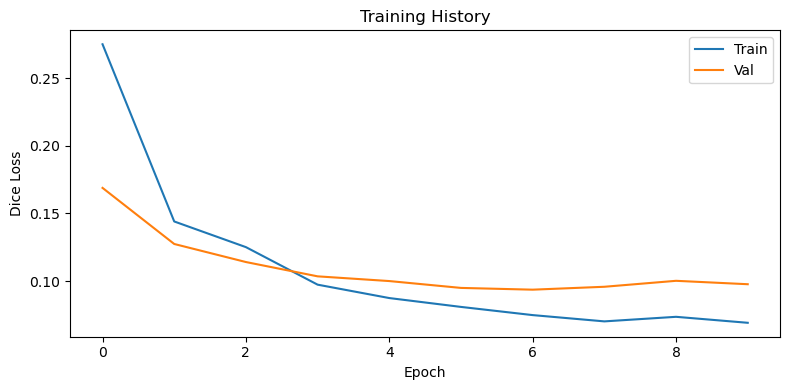

In [15]:
# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history["train"], label="Train")
plt.plot(history["val"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Dice Loss")
plt.legend()
plt.title("Training History")
plt.tight_layout()

## 7. Evaluation

In [16]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds, all_masks = [], []
with torch.no_grad():
    for images, masks in val_loader:
        preds = torch.sigmoid(model(images.to(DEVICE))).cpu().numpy() > 0.5
        all_preds.extend(preds.flatten())
        all_masks.extend(masks.numpy().flatten())

all_preds, all_masks = np.array(all_preds), np.array(all_masks)

print(f"Precision: {precision_score(all_masks, all_preds):.4f}")
print(f"Recall:    {recall_score(all_masks, all_preds):.4f}")
print(f"F1-Score:  {f1_score(all_masks, all_preds):.4f}")
print(f"IoU:       {jaccard_score(all_masks, all_preds):.4f}")

Precision: 0.9312
Recall:    0.9263
F1-Score:  0.9287
IoU:       0.8670


## 8. Predictions

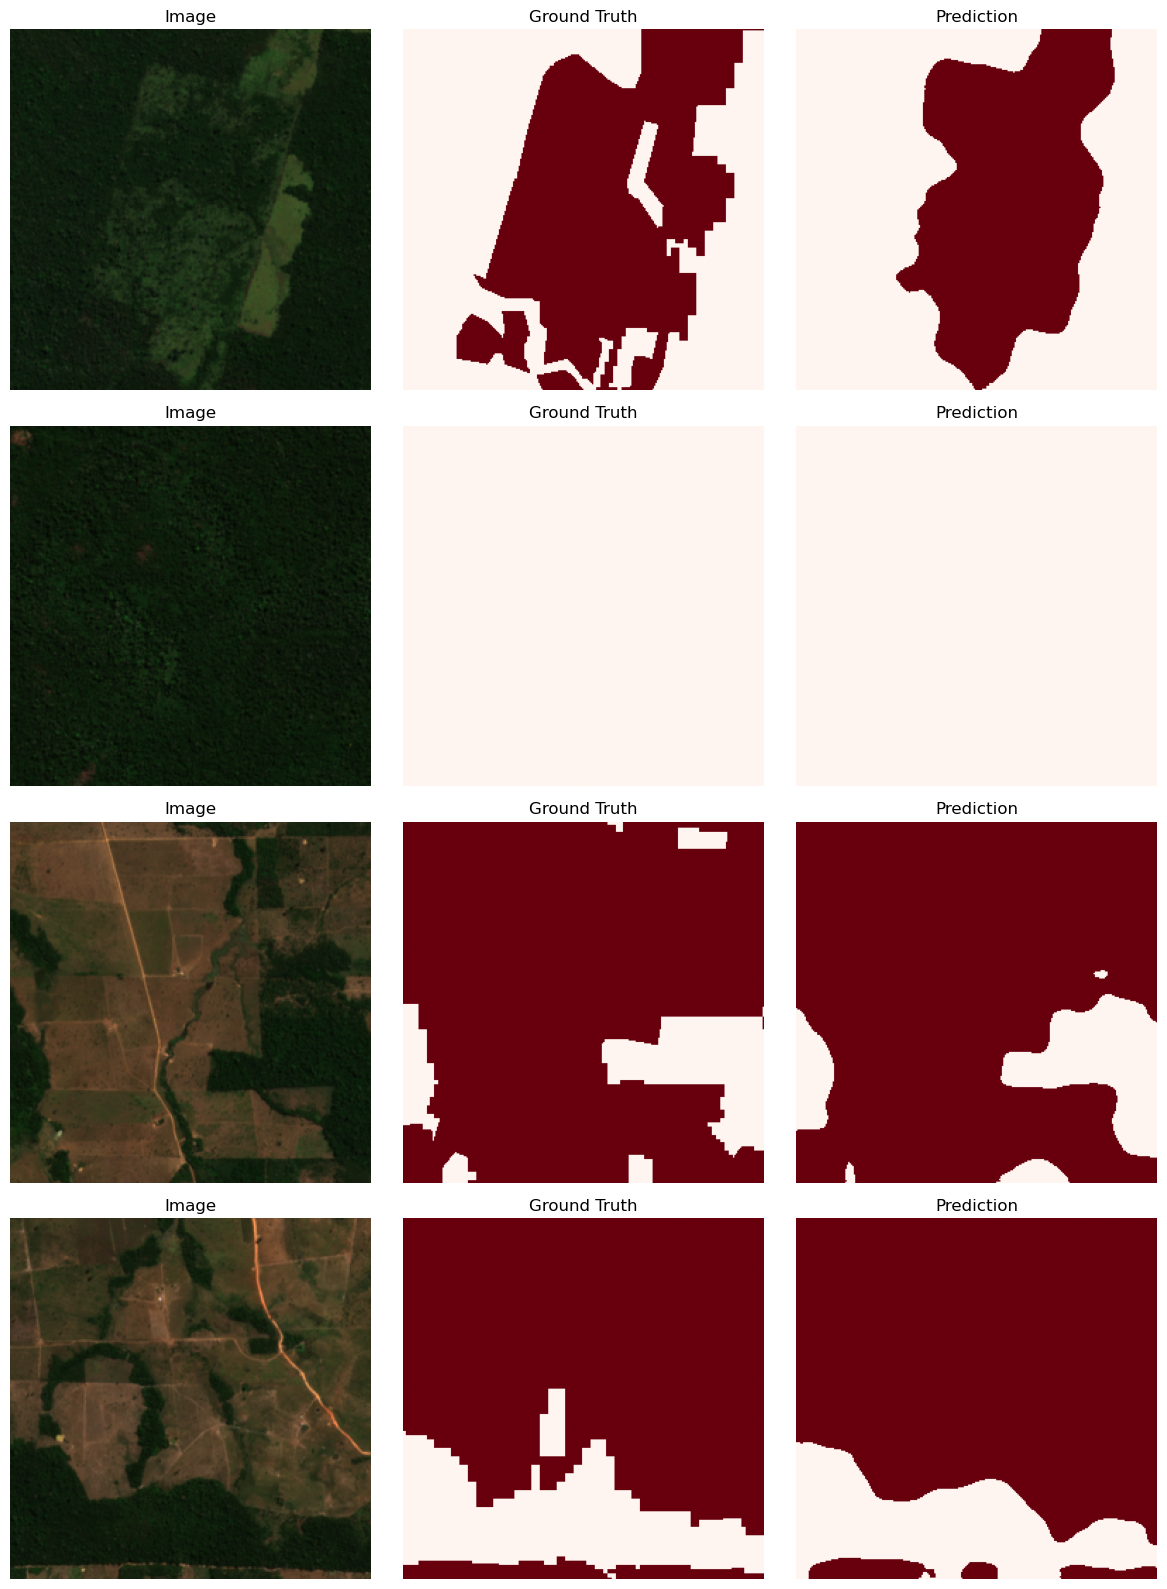

In [17]:
val_dataset = DeforestationDataset(val_chips)

fig, axes = plt.subplots(4, 3, figsize=(12, 16))
for i in range(4):
    img, mask = val_dataset[i * 50]
    with torch.no_grad():
        pred = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE))).cpu().squeeze().numpy()
    
    rgb = np.clip(img[[2,1,0]].permute(1,2,0).numpy() * 3, 0, 1)
    
    axes[i,0].imshow(rgb)
    axes[i,0].set_title("Image")
    axes[i,1].imshow(mask, cmap="Reds")
    axes[i,1].set_title("Ground Truth")
    axes[i,2].imshow(pred > 0.5, cmap="Reds")
    axes[i,2].set_title("Prediction")
    for ax in axes[i]: ax.axis("off")

plt.tight_layout()